# Recurrent Neural Networks
You should build an end-to-end machine learning pipeline using a recurrent neural network model. In particular, you should do the following:
- Load the `jena climate` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the [keras repository](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).
- Split the dataset into training, validation, and test sets. Note that you cannot split time series using [Scikit-Learn](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).
- Build an end-to-end machine learning pipeline, including a [recurrent neural network](https://keras.io/examples/timeseries/timeseries_weather_forecasting/) model.
- Optimize your pipeline by validating your design decisions.
- Test the best pipeline on the test set and report various [evaluation metrics](https://scikit-learn.org/0.15/modules/model_evaluation.html).  
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

1. Load the data.
2. Take a sample from the dataset (select measurements that are recorded at 12pm).
3. Split the data into training, validation and test sets (70%-15%-15%).
4. Create sequences.
5. Design and train your model.
6. Test your model.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import keras

In [10]:
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [11]:

df["Date Time"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")


In [12]:
# Filter rows where time is 12:00:00 (i.e., 12 PM daily)
df_12pm = df[df["Date Time"].dt.time == pd.to_datetime("12:00:00").time()].reset_index(drop=True)


In [13]:
# Determine sizes
total = len(df_12pm)
train_size = int(total * 0.7)
val_size = int(total * 0.15)

# Perform chronological split
train_df = df_12pm[:train_size]
val_df = df_12pm[train_size:train_size + val_size]
test_df = df_12pm[train_size + val_size:]


In [14]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Features and target
features = ["T (degC)", "p (mbar)", "rh (%)", "wv (m/s)"]
target = "T (degC)"
seq_len = 7  # Using past 7 days

# Normalize features based on training set only
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[features])
val_scaled = scaler.transform(val_df[features])
test_scaled = scaler.transform(test_df[features])

# Function to make sequences
def make_sequences(data, target_idx, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][target_idx])
    return np.array(X), np.array(y)

# Create sequences
target_index = features.index(target)
X_train, y_train = make_sequences(train_scaled, target_index, seq_len)
X_val, y_val = make_sequences(val_scaled, target_index, seq_len)
X_test, y_test = make_sequences(test_scaled, target_index, seq_len)


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define LSTM model
model = keras.Sequential([
    layers.Input(shape=(seq_len, len(features))),
    layers.LSTM(64),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16
)


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4034 - mae: 0.4938 - val_loss: 0.2066 - val_mae: 0.3597
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1780 - mae: 0.3383 - val_loss: 0.1951 - val_mae: 0.3419
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1764 - mae: 0.3337 - val_loss: 0.1821 - val_mae: 0.3371
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1582 - mae: 0.3160 - val_loss: 0.1683 - val_mae: 0.3234
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1528 - mae: 0.3089 - val_loss: 0.1576 - val_mae: 0.3103
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1484 - mae: 0.2989 - val_loss: 0.1475 - val_mae: 0.2982
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1326 - mae: 0.2827 - val_loss: 0.1512 - val_mae: 0.3034
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1283 - mae: 0.2807 - val_loss: 0.1397 - val_mae: 0.2910
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Test MAE: 0.26
Test RMSE: 0.32


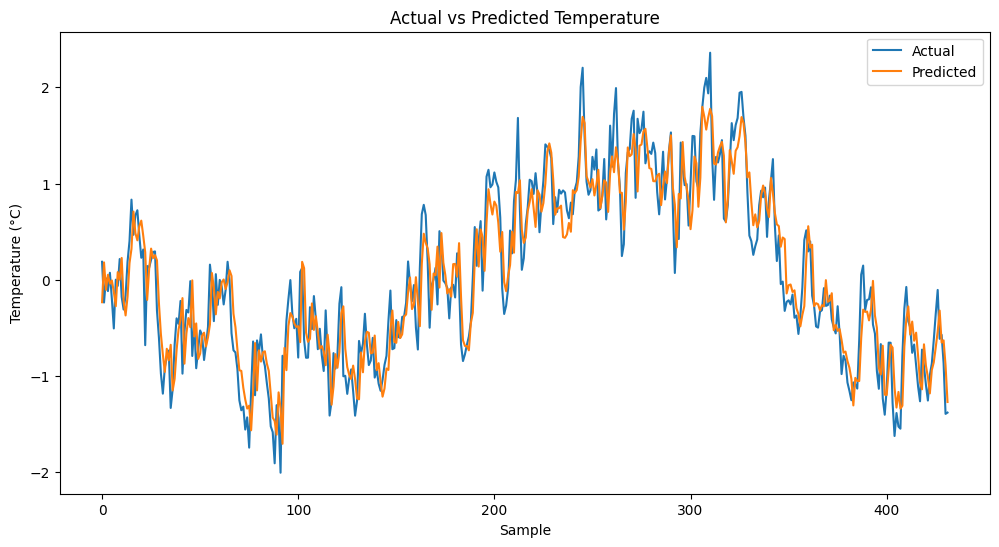

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.xlabel("Sample")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Temperature")
plt.legend()
plt.show()
